In [1]:

import cv2 as ocr
import sys
import gc
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import math
from tqdm import tqdm
import keras
from keras.utils import np_utils
import pandas as pd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense,MaxPooling2D, Dropout, Flatten
import tensorflow as tf
import keras
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm, trange

Using TensorFlow backend.
C:\Anaconda3\Lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:


# # imageFiles = TopKimagePathList
# counter = 0
# prevClass = -1
# imageDirTrain = 'Gen2000-Top10-64x64/TrainingSet'
# imageDirVal = 'Gen2000-Top10-64x64/ValidationSet'
# print('Getting Training Data..')
# x_train,y_train = getData(dataPath=imageDirTrain)
# print('Getting Validation Data..')
# x_test,y_test = getData(dataPath=imageDirVal)

# # print(input_label_list)
# nmbr_classes = max(y_train)+1

# y_train = keras.utils.to_categorical(y_train,num_classes=nmbr_classes)
# y_test = keras.utils.to_categorical(y_test,num_classes=nmbr_classes)
# x_train = x_train.astype('float32')
# x_train = (255.1-x_train)/255.0
# x_train = x_train.reshape(-1,64,64,1)
# x_test = x_test.astype('float32')
# x_test = (255.1-x_test)/255.0
# x_test = x_test.reshape(-1,64,64,1)
# x_train,y_train = shuffle(x_train,y_train, random_state=2)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

def deepModel(num_classes = 2, input_shape  = (64,64,1)):
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128,kernel_size=(3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256,kernel_size=(1, 1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(2,kernel_size=(1, 1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model
# LOG_DIR = 'logs/CNN_VGG'
# tensorCallback = keras.callbacks.TensorBoard(log_dir=LOG_DIR
#                             , batch_size=32
#                             , write_graph=True
#                             , write_grads=True
#                             , write_images=False
#                             , embeddings_freq=0
#                             , embeddings_layer_names=None
#                             , embeddings_metadata=None)


# filepath="weights/inverted-10-Class-valSplit-{epoch:02d}-{loss:.2f}-{acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath
#            , monitor='loss'
#            , verbose=1
#            , save_best_only=True
#            , mode='min'
#             ,period = 100
#            , save_weights_only=True)

# callbacks_list = [tensorCallback,checkpoint]

In [3]:


def getImagesandModels():
    net_dis = deepModel(num_classes=2, input_shape  = (64,64,1))
    net_dis.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
    #               optimizer = keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    net_sim = deepModel(num_classes=2, input_shape  = (64,64,1))
    net_sim.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
    #               optimizer = keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    # oneShotModel.summary()

    imgKnown  = ocr.imread(img1,0)
    imgKnown = imgKnown.astype('float32')
    imgKnown = (255.1-imgKnown)/255
    imgKnown = imgKnown.reshape(64,64,1)

    imgQuery  = ocr.imread(img2,0)
    imgQuery = imgQuery.astype('float32')
    imgQuery = (255.1-imgQuery)/255
    imgQuery = imgQuery.reshape(64,64,1)

    return (imgKnown,imgQuery, net_dis, net_sim)

In [4]:


def trainSimandDissim(epochs = 200, patienceLevel = 20, verbose = 0):
#     earlyStoppingLoss = keras.callbacks.EarlyStopping(
#         monitor='loss', min_delta=0.01, patience=patienceLevel, verbose=0, mode='min')
#     earlyStoppingAcc = keras.callbacks.EarlyStopping(
#         monitor='acc', min_delta=0.01, patience=patienceLevel, verbose=0, mode='max')
#     callbacksList = [earlyStopping]
    batches = 2
    print('\ntrain dissim start...')
    x = np.array([imgKnown,imgQuery])
    y = [1,0]
    y = keras.utils.to_categorical(y,num_classes=2)
    hist_dis = net_dis.fit(
                           x,
                           y,
                           epochs=epochs,
                           verbose=verbose,
                           batch_size = batches
#                                 ,
#                             callbacks = callbacksList
                           )


    print('\n================================')
    print('train similar network start...')
    x = np.array([imgKnown,imgQuery])
    y = [1,1]
    y = keras.utils.to_categorical(y,num_classes=2)
    hist_sim = net_sim.fit(
                           x,
                           y,
                           epochs=epochs,
                           verbose=verbose,
                           batch_size = batches
#                                 ,
#                             callbacks = callbacksList
                           )




In [5]:


def losses():
    print('average losses similar:')
    df = pd.DataFrame(hist_sim.history)
    print( 'acc : %.5f, loss : %.5f ' %(np.average(df['acc']), np.average(df['loss'])))

    print('\naverage losses dissimilar:')
    df = pd.DataFrame(hist_dis.history)
    print( 'acc : %.5f, loss : %.5f ' %(np.average(df['acc']), np.average(df['loss'])))

In [6]:


def similarityScore(printImages = False, seekLayer = 1):
    from keras import backend as K

    inp = net_sim.input   # y = [same class both images]                                        
    outputs = [layer.output for layer in net_sim.layers]          
    functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  

    imgKnown  = ocr.imread(img1,0)
    imgKnown = imgKnown.astype('float32')
    imgKnown = (255.1-imgKnown)/255
    imgKnown = imgKnown.reshape(64,64,1)

    imgQuery  = ocr.imread(img2,0)
    imgQuery = imgQuery.astype('float32')
    imgQuery = (255.1-imgQuery)/255
    imgQuery = imgQuery.reshape(64,64,1)

    from matplotlib import pyplot as plt
    if (printImages):
        rows = 1
        columns = 2
        fig, axesarr = plt.subplots(rows,columns)
        axesarr[0].imshow(imgKnown.reshape(64,64))
        axesarr[1].imshow(imgQuery.reshape(64,64))
        plt.show()

    test = imgKnown.reshape(-1,64,64,1)
#     print(test.shape)
    layer_outs = [func([test, 1.]) for func in functors]
    im1 = np.array(layer_outs[seekLayer][0])
    # print('features im1 :',im1)

    test = imgQuery.reshape(-1,64,64,1)
#     print(test.shape)
    layer_outs = [func([test, 1.]) for func in functors]
    im2 = np.array(layer_outs[seekLayer][0])
    # print('features im2 :',im2)
    t = 0
    print('\n contrastive loss when y = 1 :sim')
    with tf.Session() as sess:
        t = contrastive_loss(im1,im2,1,margin=0.2).eval()
        print(t)
    return t

    # print('\n contrastive loss when y = 0 :')
    # with tf.Session() as sess:
    #     print(contrastive_loss(im1,im2,0,margin=0.2).eval())

In [7]:


def dissimilarityScore(printImages = False, seekLayer = 1, originShiftBy = 6):
    from keras import backend as K

    inp = net_dis.input     # y = [classifiying in diferent classes]                          
    outputs = [layer.output for layer in net_dis.layers]          
    functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  

    imgKnown  = ocr.imread(img1,0)
    imgKnown = imgKnown.astype('float32')
    imgKnown = (255.1-imgKnown)/255
    imgKnown = imgKnown.reshape(64,64,1)

    imgQuery  = ocr.imread(img2,0)
    imgQuery = imgQuery.astype('float32')
    imgQuery = (255.1-imgQuery)/255
    imgQuery = imgQuery.reshape(64,64,1)

    from matplotlib import pyplot as plt

    if (printImages):
        rows = 1
        columns = 2
        fig, axesarr = plt.subplots(rows,columns)
        axesarr[0].imshow(imgKnown.reshape(64,64))
        axesarr[1].imshow(imgQuery.reshape(64,64))
        plt.show()

    test = imgKnown.reshape(-1,64,64,1)
#     print(test.shape)
    layer_outs = [func([test, 1.]) for func in functors]
    im1 = np.array(layer_outs[seekLayer][0])
    # print('features im1 :',im1)

    test = imgQuery.reshape(-1,64,64,1)
#     print(test.shape)
    layer_outs = [func([test, 1.]) for func in functors]
    im2 = np.array(layer_outs[seekLayer][0])
    # print('features im2 :',im2)
    t = 0
    print('\n contrastive loss when y = 1 :dissim')
    with tf.Session() as sess:
        t = contrastive_loss(im1,im2,1,margin=0.2).eval()
        print(originShiftBy - t)
    
    return originShiftBy - t

    # print('\n contrastive loss when y = 0 :dissim')
    # with tf.Session() as sess:
    #     print(contrastive_loss(im1,im2,0,margin=0.2).eval())

In [8]:

def contrastive_loss(model1, model2, y, margin):
    with tf.name_scope("contrastive-loss"):
        d = tf.sqrt(tf.reduce_sum(tf.pow(model1-model2, 2), 1, keep_dims=True))
        tmp= y * tf.square(d)    
        tmp2 = (1 - y) * tf.square(tf.maximum((margin - d),0))
        return tf.reduce_mean(tmp + tmp2) /2

In [9]:

def getData(dataPath='pathToData',channels = 0, pathSplitIndex = 2, classCount = None, classValue = None):
    imageClass = []
    imageFiles = [] 
    input_label_list = []
    input_data_list = []   
    selectedFilePaths = []
    imageFiles = [dataPath+'/'+f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    for imgF in tqdm(imageFiles, total=len(imageFiles), unit="files"):  
        c = int(imgF.split('/')[pathSplitIndex][0:4])
        if( classCount!=None and classValue == None):
            imageClass.append(c) 
            if(len(Counter(imageClass).keys())>classCount):
                imageClass[classCount] = imageClass[classCount-1]
            else:
                input_label_list.append(c)
                input_data_list.append(ocr.imread(imgF,channels))
                selectedFilePaths.append(imgF)
        elif(classCount==None and classValue!=None):
            if(c in classValue):
                input_label_list.append(c)
                input_data_list.append(ocr.imread(imgF,channels))
                selectedFilePaths.append(imgF)
        imageClass = list(set(imageClass))
    return np.array(input_data_list),np.array(input_label_list),np.array(selectedFilePaths)



X-2-All-Data/ValidationSet/0883a_num1.png <-----> X-2-All-Data/ValidationSet/0883a_num3.png


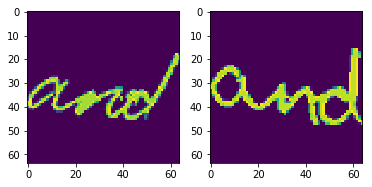


train dissim start...

train similar network start...

 contrastive loss when y = 1 :dissim
-11.4429330826
==========XXXXXXXXXXXXXXXXXXXXXXXXX=============


In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from numpy.random import choice, permutation
from itertools import combinations
import cv2 as ocr
import sys
import gc
import numpy as np
from os import listdir
from os.path import isfile, join
imageDir = 'X-2-All-Data/ValidationSet'
classValueList = [833, 66, 883, 801,34]
# x, _, imageFiles = getData(dataPath=imageDir,pathSplitIndex = 2, channels=0, classCount=None, classValue=classValueList)
# print(imageFiles)
# listLeft = []
# listRight = []
# for i,j in combinations(imageFiles, 2):
#     listLeft.append(i)
#     listRight.append(j)
df = pd.DataFrame()
df = df.from_csv('paths.csv')

img1 = df['left'][10]
img2 = df['right'][10]
print(img1,'<----->',img2)
imgKnown, imgQuery, net_dis, net_sim = getImagesandModels()
rows = 1
columns = 2
fig, axesarr = plt.subplots(rows,columns)
axesarr[0].imshow(imgKnown.reshape(64,64))
axesarr[1].imshow(imgQuery.reshape(64,64))
plt.show()
# net_dis.summary()
trainSimandDissim(epochs = 500, verbose=0)
# # losses()
# sc_sim = similarityScore(printImages = False, seekLayer=9)
sc_dis = dissimilarityScore(printImages = False, seekLayer=9, originShiftBy =  0)
print("==========XXXXXXXXXXXXXXXXXXXXXXXXX=============")
